# P3 - CONCEPTION APPLICATION POUR SANTE PUBLIQUE

L'agence "*Santé publique France*" a lancé un appel à projets pour trouver des idées innovantes d’**applications** en lien avec l'alimentation.

<p>Je propose alors une application <strong>QUALECO</strong> qui permet de définir, pour un aliment, deux SCORES :</p>
<ul>
    <li> <strong>QUAL</strong> : qualifiant si l'aliment est nutritif et sain pour l'homme ; </li>
    <li> <strong>ECO</strong> : notant si l'aliment est respectueux de l'environnement.</li>
</ul>

<hr/>

# *Partie 1 : Nettoyage des données*

<hr/>

## I. Importation des Librairies utiles

Ici on importe les librairies utilisés tout au long de l'étude.

In [1]:
# librairies pour les graphes
%matplotlib  inline
import matplotlib.pyplot as plt
import seaborn as sns

# librairies pour les analyses
import pandas as pd
import numpy as np
import missingno as msno
import math

<hr />

## II. Importation des données
<p> Ici on importe les données à partir des fichiers .csv téléchargés sur le site de la Banque Mondiale. </p>

In [2]:
# importation du jeu de données à partir de .csv
mini_df = pd.read_csv('../Dataset/en.openfoodfacts.org.products.csv',sep="\t", encoding="utf-8", nrows=500000, low_memory=False)

In [3]:
#affichage des premières lignes
mini_df.head(3)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
mini_df.info(verbose=True,null_counts=True)

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 186 columns):
 #    Column                                      Non-Null Count   Dtype  
---   ------                                      --------------   -----  
 0    code                                        500000 non-null  object 
 1    url                                         500000 non-null  object 
 2    creator                                     499999 non-null  object 
 3    created_t                                   500000 non-null  int64  
 4    created_datetime                            500000 non-null  object 
 5    last_modified_t                             500000 non-null  int64  
 6    last_modified_datetime                      500000 non-null  object 
 7    product_name                                484320 non-null  object 
 8    abbreviated_product_name                    0 non-null       float64
 9    generic_name                                11280 non-nul

<hr/>

## III. Traitements des données

### 1. Définition des fonctions
<p> Ici on définit les fonctions utilisées pour les analyses. </p>

* **Selection**

In [6]:
def data_select(data,colonnes):
    return data[colonnes]

* **Exploration des valeurs manquantes**

In [7]:
def nan_explore(data):
    fig, (ax1,ax2) = plt.subplots(2, 1,figsize=(25,10))
    msno.matrix(df,ax=plt.subplot(211))
    msno.bar(df,ax=plt.subplot(212))

* **Suppression des lignes vides**

In [8]:
def empty_rows_delete(data,n_col):
    empty_rows = data[data.isnull().sum(axis = 1)>=n_col].index
    data = data.loc[~data.index.isin(empty_rows)].reset_index(drop=True)
    
    return data

* **Visualisation des outliers**

In [9]:
def outlier_explore(data,colonnes):
    medianprops = dict(linestyle='-.', linewidth=2.5, color='green')
    meanpointprops = dict(marker='D',markerfacecolor='red',markeredgecolor='red',markersize=8)
    data[colonnes].boxplot(figsize=(25,5), showmeans=True,medianprops=medianprops,meanprops=meanpointprops)

* **Traitement des outliers**

In [10]:
def outlier_treat(data):
    colonnes = ['nutriscore_score',
                'energy-kcal_100g','saturated-fat_100g','sugars_100g','sodium_100g',
                'proteins_100g','fiber_100g']#'fat_100g',
    
    for col in colonnes:
        if col == 'nutriscore_score':
            Lower_Whisker = -15
            Upper_Whisker = 40
        else:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            Lower_Whisker = Q1 - (1.5 * IQR)
            Upper_Whisker = Q3 + (1.5 * IQR)
        data = data[(data[col] >= Lower_Whisker) & (data[col] <= Upper_Whisker)]
    
    return data

* **Traitement des valeurs manquantes**

    - Pour les variables qualitatives 
    (complétion par la valeur "unknown")

In [11]:
def nan_string_replace(data):
    string_columns = [col for col in data.columns if (data[col].dtypes!='float64') & (col!='nutriscore_grade')]
    
    for col in string_columns:
        data[col].fillna(value='unknown', inplace=True)
    
    return data

    - Pour les variables quantitatives
    (complétion par la valeur médiane pour les aliments de même catégorie, sinon par la valeur médiane de toute la colonne)

In [12]:
def nan_float_replace(data):
    float_columns = [col for col in data.columns if (data[col].dtypes=='float64') & (col!='nutriscore_score')]
    
    for col in float_columns:
        for categ in data['main_category'].unique():
            mean_value = np.nanmedian(data.loc[(data['main_category']==categ),col])
            if math.isnan(mean_value):
                mean_value = np.nanmedian(data[col])
            data.loc[(data['main_category']==categ),col] = data.loc[(data['main_category']==categ),col].fillna(mean_value)
            
    return data

    - Pour les nutriscores : score et grade
    (par application de la formule de nutriscore de Santé Publique)

In [13]:
def nutri_score(data):
    en = data['energy-kcal_100g']
    if en <= 335:
        NRJ = 0
    elif en > 3350:
        NRJ = 10
    else :
        NRJ = (en-1)//335
        
    su = data['sugars_100g']
    if su <= 4.5:
        sucre = 0
    elif su > 45:
        sucre = 10
    else:
        sucre = (su - 0.1)//4.5
        
    gr = data['saturated-fat_100g']
    if gr <= 1:
        gras = 0
    elif gr > 10:
        gras = 10
    else:
        gras = (gr - 0.01)//1
        
    se = data['sodium_100g']
    if se <= 90:
        sel = 0
    elif se > 900:
        sel = 10
    else:
        sel = (se - 1)//90

    fi = data['fiber_100g']
    if fi <= 0.9:
        fibre = 0
    elif fi > 0.9:
        fibre = 1
    elif fi > 1.9:
        fibre = 2
    elif fi > 2.8:
        fibre = 3
    elif fi > 3.7:
        fibre = 4  
    else:
        fibre = 5
        
    pro = data['proteins_100g']
    if pro <= 1.6:
        prot = 0
    elif pro > 8:
        prot = 5
    else:
        prot = (pro - 0.1)//1.6
    
    return (NRJ + sucre + gras + sel) - (fibre + prot)

In [14]:
def nutri_grade(nutriscore):
    
    if nutriscore <= -1:
        grade = 'a'
    elif nutriscore <= 2:
        grade = 'b'
    elif nutriscore <= 10:
        grade = 'c'
    elif nutriscore <= 18:
        grade = 'd'
    else:
        grade = 'e'
    
    return grade

In [15]:
def nan_nutri_replace(data):
    for i in data.index:
        if math.isnan(data.loc[i,'nutriscore_score']):
            data.loc[i,'nutriscore_score'] = nutri_score(data.loc[i])
        if pd.isnull(data.loc[i,'nutriscore_grade']):
            data.loc[i,'nutriscore_grade'] = nutri_grade(data.loc[i,'nutriscore_score'])
    
    return data

### 2. Execution des fonctions
<p> Ici on réalise l'analyse en executant les fonctions appropriées. </p>

* **Selection des données**

In [16]:
columns = ['product_name','main_category',
           'nutriscore_grade','nutriscore_score',
           'energy-kcal_100g','saturated-fat_100g','sugars_100g','sodium_100g',#'fat_100g',  
           'proteins_100g','fiber_100g','fruits-vegetables-nuts_100g',
           'additives_n',#'additives_tags',
           'ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n',
           'carbon-footprint_100g',
           'labels',
           'origins','manufacturing_places',
           'packaging',
           'no_nutriments']

In [17]:
df = data_select(mini_df,columns)
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,carbon-footprint_100g,labels,origins,manufacturing_places,packaging,no_nutriments
0,Vitória crackers,NaN,NaN,NaN,375.0,3.08,15.0,0.56,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hamburguesas de ternera 100%,NaN,NaN,NaN,874.9,6.10,1.0,0.84,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,moutarde au moût de raisin,en:mustards,d,18.0,NaN,2.20,22.0,1.84,5.1,0.0,NaN,0.0,0.0,0.0,NaN,Delois france,NaN,NaN,NaN,NaN


* **Gestion des données dupliquées**

Identification des valeurs dupliquées

In [18]:
df.duplicated().sum()

49425

Suppression des valeurs dupliquées

In [19]:
df = df.drop_duplicates()
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,fruits-vegetables-nuts_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,carbon-footprint_100g,labels,origins,manufacturing_places,packaging,no_nutriments
0,Vitória crackers,NaN,NaN,NaN,375.0,3.08,15.0,0.56,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hamburguesas de ternera 100%,NaN,NaN,NaN,874.9,6.10,1.0,0.84,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,moutarde au moût de raisin,en:mustards,d,18.0,NaN,2.20,22.0,1.84,5.1,0.0,NaN,0.0,0.0,0.0,NaN,Delois france,NaN,NaN,NaN,NaN


* **Exploration des valeurs manquantes**

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


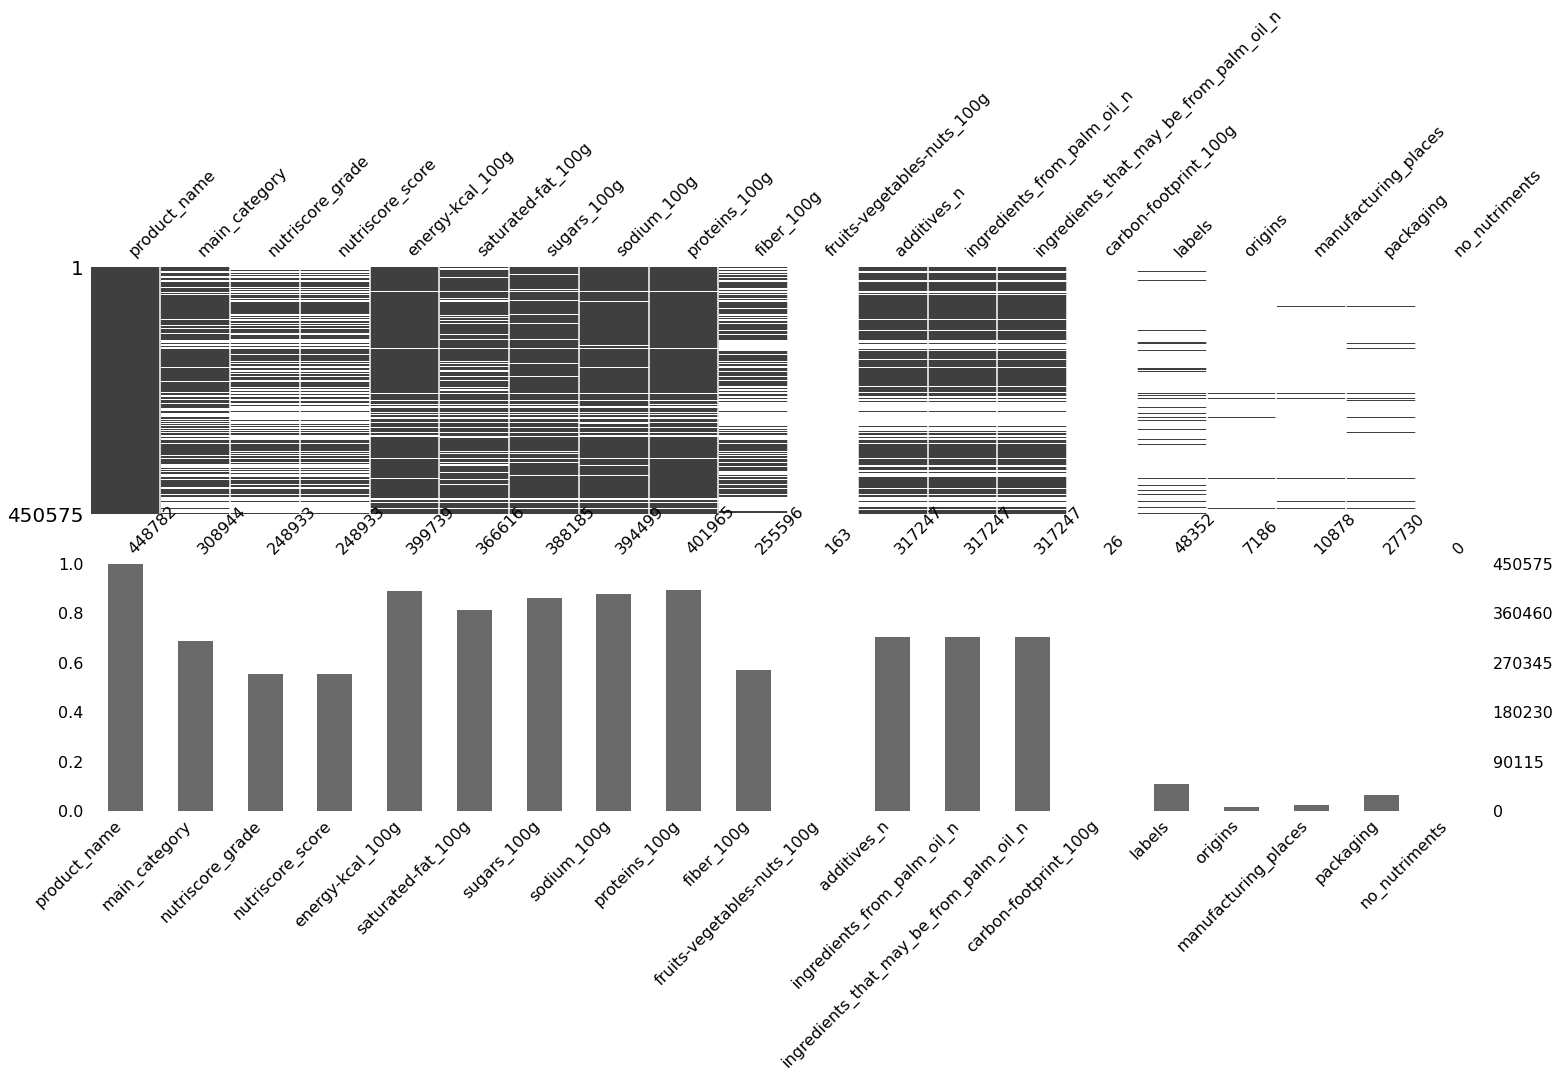

In [20]:
nan_explore(df)

* **Suppression des colonnes non pertinentes (Taux de NaN > 95%)**

In [21]:
select_columns = [col for col in columns if col not in ['fruits-vegetables-nuts_100g','carbon-footprint_100g',
                                                        'no_nutriments']]#'origins','manufacturing_places',

In [22]:
df = data_select(mini_df,select_columns)
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,labels,origins,manufacturing_places,packaging
0,Vitória crackers,NaN,NaN,NaN,375.0,3.08,15.0,0.56,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Cacao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Filetes de pollo empanado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Hamburguesas de ternera 100%,NaN,NaN,NaN,874.9,6.10,1.0,0.84,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,moutarde au moût de raisin,en:mustards,d,18.0,NaN,2.20,22.0,1.84,5.1,0.0,0.0,0.0,0.0,Delois france,NaN,NaN,NaN


* **Vérification de la sélection**

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


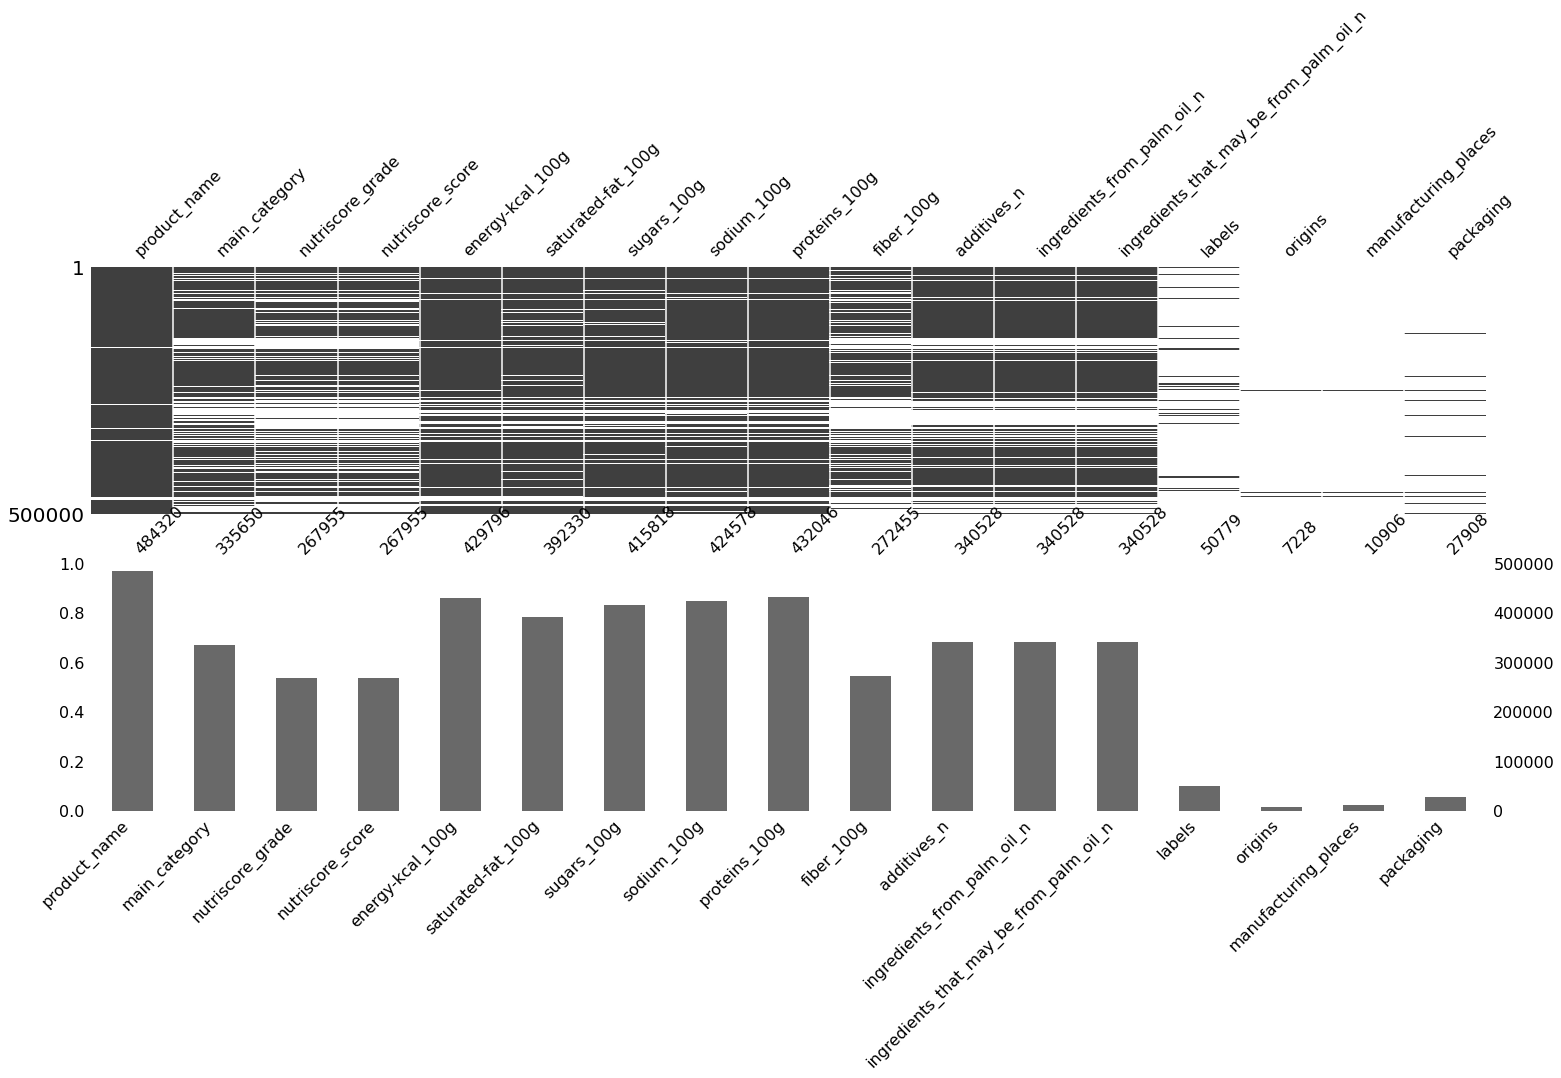

In [23]:
nan_explore(df)

* **Définition et Suppression des lignes vides**

In [24]:
df = empty_rows_delete(df,16)
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,labels,origins,manufacturing_places,packaging
0,Vitória crackers,NaN,NaN,NaN,375.0,3.08,15.0,0.560,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hamburguesas de ternera 100%,NaN,NaN,NaN,874.9,6.10,1.0,0.840,15.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,moutarde au moût de raisin,en:mustards,d,18.0,NaN,2.20,22.0,1.840,5.1,0.0,0.0,0.0,0.0,Delois france,NaN,NaN,NaN
3,Sfiudwx,fr:xsf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sauce Sweety chili 0%,NaN,NaN,NaN,21.0,0.00,0.4,0.816,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **Visualisation de la distribution (boxplot)**

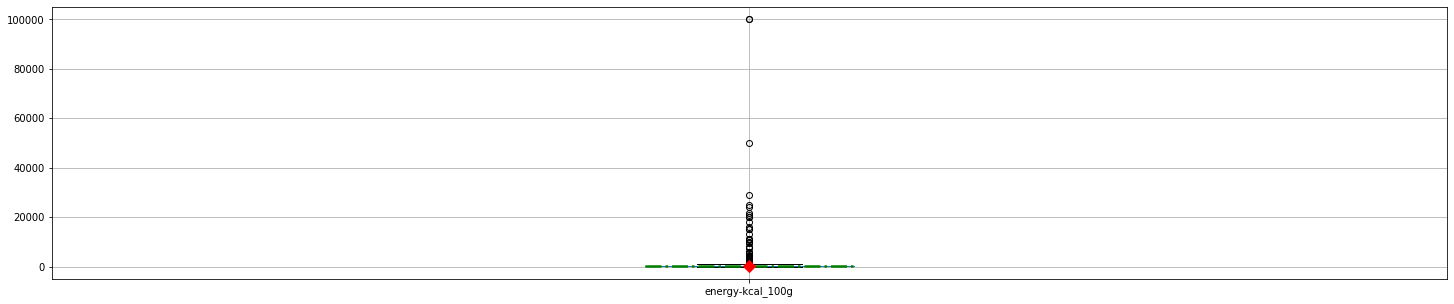

In [25]:
outlier_explore(df,['energy-kcal_100g'])

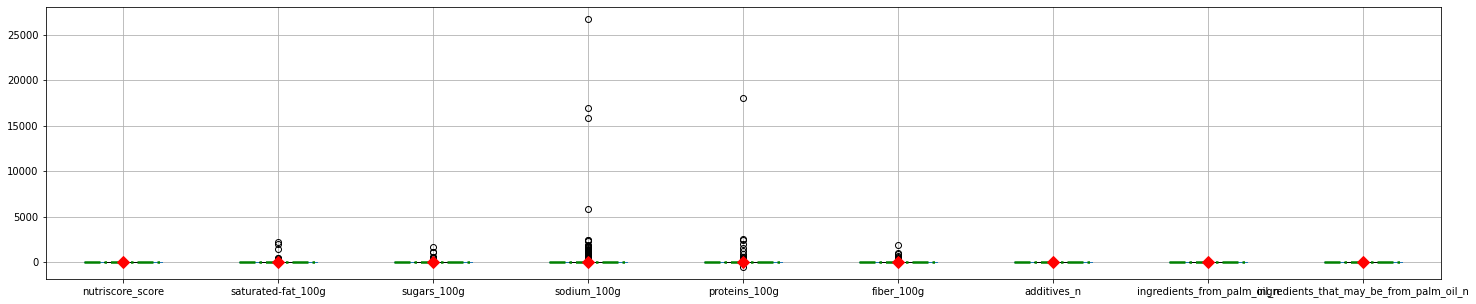

In [26]:
outlier_explore(df,[col for col in df.columns if col!='energy-kcal_100g'])

* **Gestion des Outliers**

In [27]:
df = outlier_treat(df)

* **Vérification de la distribution après traitements des outliers**

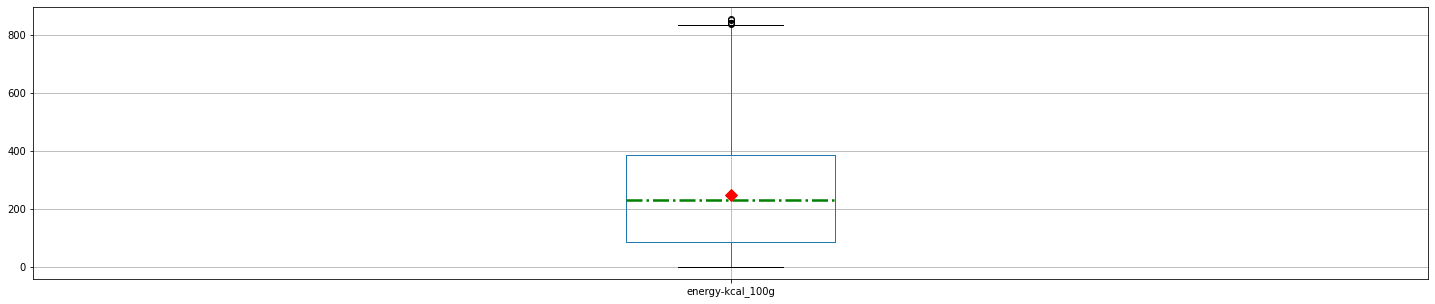

In [28]:
outlier_explore(df,['energy-kcal_100g'])

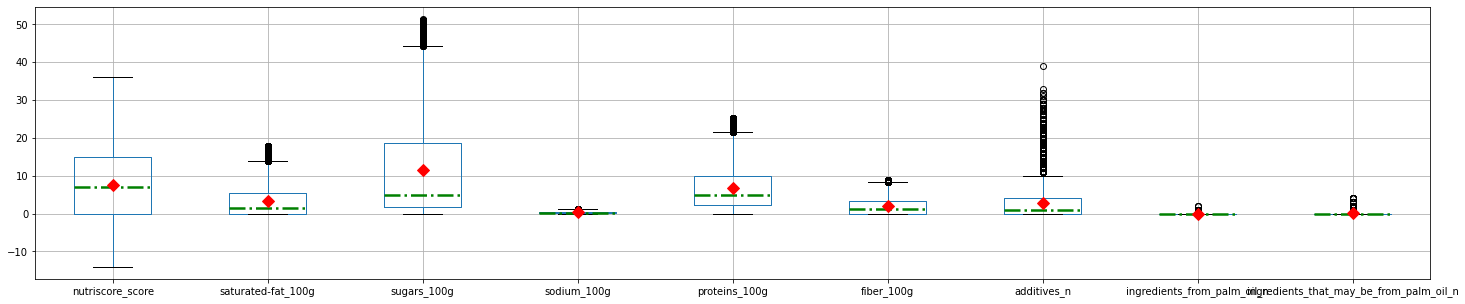

In [29]:
outlier_explore(df,[col for col in df.columns if col!='energy-kcal_100g'])

* **Gestion des valeurs manquantes pour les variables qualitatives**

In [30]:
df = nan_string_replace(df)
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,labels,origins,manufacturing_places,packaging
16,Tarte noix de coco,en:coconut-pies,d,14.0,381.0,15.5,21.9,0.0400,4.60,4.4,NaN,NaN,NaN,unknown,unknown,unknown,"barquette,plastique"
23,Compote de poire,en:pear-compotes,a,-2.0,157.0,0.0,27.0,0.0000,0.60,3.6,NaN,NaN,NaN,unknown,unknown,unknown,unknown
53,BAguette bressan,en:baguettes,a,-4.0,160.0,0.5,0.6,0.1432,9.50,1.6,3.0,0.0,0.0,unknown,unknown,unknown,unknown
283,Salade Cesar,en:leaf-vegetables,c,6.0,290.0,7.0,0.0,0.8640,22.00,2.0,3.0,1.0,0.0,unknown,Québec,Brossard Québec,Frais
314,Chaussons tressés aux pommes,en:apple-turnovers,c,9.0,260.0,2.0,24.7,0.2590,3.33,2.0,3.0,0.0,0.0,unknown,Québec,Brossard Québec,Frais


* **Gestion des valeurs manquantes pour les variables quantitatives**

In [31]:
df = nan_float_replace(df)
df.head()

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,labels,origins,manufacturing_places,packaging
16,Tarte noix de coco,en:coconut-pies,d,14.0,381.0,15.5,21.9,0.0400,4.60,4.4,3.0,0.0,0.0,unknown,unknown,unknown,"barquette,plastique"
23,Compote de poire,en:pear-compotes,a,-2.0,157.0,0.0,27.0,0.0000,0.60,3.6,0.0,0.0,0.0,unknown,unknown,unknown,unknown
53,BAguette bressan,en:baguettes,a,-4.0,160.0,0.5,0.6,0.1432,9.50,1.6,3.0,0.0,0.0,unknown,unknown,unknown,unknown
283,Salade Cesar,en:leaf-vegetables,c,6.0,290.0,7.0,0.0,0.8640,22.00,2.0,3.0,1.0,0.0,unknown,Québec,Brossard Québec,Frais
314,Chaussons tressés aux pommes,en:apple-turnovers,c,9.0,260.0,2.0,24.7,0.2590,3.33,2.0,3.0,0.0,0.0,unknown,Québec,Brossard Québec,Frais


* **Calcul des nutriscores (score et grade) manquants**

In [32]:
df = nan_nutri_replace(df)
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,labels,origins,manufacturing_places,packaging
16,Tarte noix de coco,en:coconut-pies,d,14.0,381.0,15.5,21.9,0.0400,4.60,4.4,3.0,0.0,0.0,unknown,unknown,unknown,"barquette,plastique"
23,Compote de poire,en:pear-compotes,a,-2.0,157.0,0.0,27.0,0.0000,0.60,3.6,0.0,0.0,0.0,unknown,unknown,unknown,unknown
53,BAguette bressan,en:baguettes,a,-4.0,160.0,0.5,0.6,0.1432,9.50,1.6,3.0,0.0,0.0,unknown,unknown,unknown,unknown
283,Salade Cesar,en:leaf-vegetables,c,6.0,290.0,7.0,0.0,0.8640,22.00,2.0,3.0,1.0,0.0,unknown,Québec,Brossard Québec,Frais
314,Chaussons tressés aux pommes,en:apple-turnovers,c,9.0,260.0,2.0,24.7,0.2590,3.33,2.0,3.0,0.0,0.0,unknown,Québec,Brossard Québec,Frais


* **Rajout d'une colonne "ingredients_palm_oil"** (somme des ingrédients provenant et qui pourraient provenir de l'huile de palm)

In [33]:
df['ingredients_palm_oil_n'] = df['ingredients_from_palm_oil_n'] + df['ingredients_that_may_be_from_palm_oil_n']

* **Rajout de colonnes** (pour les variables qualitatives pour l'ECOSCORE)

In [34]:
for i in df.index:
    if ('bio' in df.loc[i,'labels']) | ('Bio' in df.loc[i,'labels']) | ('BIO' in df.loc[i,'labels']):
        df.loc[i,'labels'] = 'biologic'
        df.loc[i,'biologic'] = 1
    elif df.loc[i,'labels'] == 'unknown':
        df.loc[i,'labels'] = 'unknown'
        df.loc[i,'biologic'] = 2
    else:
        df.loc[i,'labels'] = 'others'
        df.loc[i,'biologic'] = 0
        
    if ('plast' in df.loc[i,'packaging']) | ('Plast' in df.loc[i,'packaging']) | ('PLAST' in df.loc[i,'packaging']):
        df.loc[i,'packaging'] = 'plastic'
        df.loc[i,'plastic'] = 1
    elif df.loc[i,'packaging'] == 'unknown':
        df.loc[i,'packaging'] = 'unknown'
        df.loc[i,'plastic'] = 2
    else:
        df.loc[i,'packaging'] = 'others'
        df.loc[i,'plastic'] = 0
        
    if ('France' in df.loc[i,'origins']) | ('france' in df.loc[i,'origins']) | ('FRANCE' in df.loc[i,'origins']):
        df.loc[i,'origins'] = 'france'
        df.loc[i,'ingredients_france'] = 1
    elif df.loc[i,'origins'] == 'unknown':
        df.loc[i,'origins'] = 'unknown'
        df.loc[i,'ingredients_france'] = 2
    else:
        df.loc[i,'origins'] = 'others'
        df.loc[i,'ingredients_france'] = 0
        
    if ('France' in df.loc[i,'manufacturing_places']) | ('france' in df.loc[i,'manufacturing_places']) | ('FRANCE' in df.loc[i,'manufacturing_places']):
        df.loc[i,'manufacturing_places'] = 'france'
        df.loc[i,'made_france'] = 1
    elif df.loc[i,'manufacturing_places'] == 'unknown':
        df.loc[i,'manufacturing_places'] = 'unknown'
        df.loc[i,'made_france'] = 2
    else:
        df.loc[i,'manufacturing_places'] = 'others'
        df.loc[i,'made_france'] = 0

In [35]:
df.drop(['ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n'],1,inplace=True)

In [36]:
df.head()

,product_name,main_category,nutriscore_grade,nutriscore_score,energy-kcal_100g,saturated-fat_100g,sugars_100g,sodium_100g,proteins_100g,fiber_100g,additives_n,labels,origins,manufacturing_places,packaging,ingredients_palm_oil_n,biologic,plastic,ingredients_france,made_france
16,Tarte noix de coco,en:coconut-pies,d,14.0,381.0,15.5,21.9,0.0400,4.60,4.4,3.0,unknown,unknown,unknown,plastic,0.0,2.0,1.0,2.0,2.0
23,Compote de poire,en:pear-compotes,a,-2.0,157.0,0.0,27.0,0.0000,0.60,3.6,0.0,unknown,unknown,unknown,unknown,0.0,2.0,2.0,2.0,2.0
53,BAguette bressan,en:baguettes,a,-4.0,160.0,0.5,0.6,0.1432,9.50,1.6,3.0,unknown,unknown,unknown,unknown,0.0,2.0,2.0,2.0,2.0
283,Salade Cesar,en:leaf-vegetables,c,6.0,290.0,7.0,0.0,0.8640,22.00,2.0,3.0,unknown,others,others,others,1.0,2.0,0.0,0.0,0.0
314,Chaussons tressés aux pommes,en:apple-turnovers,c,9.0,260.0,2.0,24.7,0.2590,3.33,2.0,3.0,unknown,others,others,others,0.0,2.0,0.0,0.0,0.0


* **Vérification des données après traitements**

/home/fanjama/snap/jupyter/common/lib/python3.7/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  "Plotting a sparkline on an existing axis is not currently supported. "


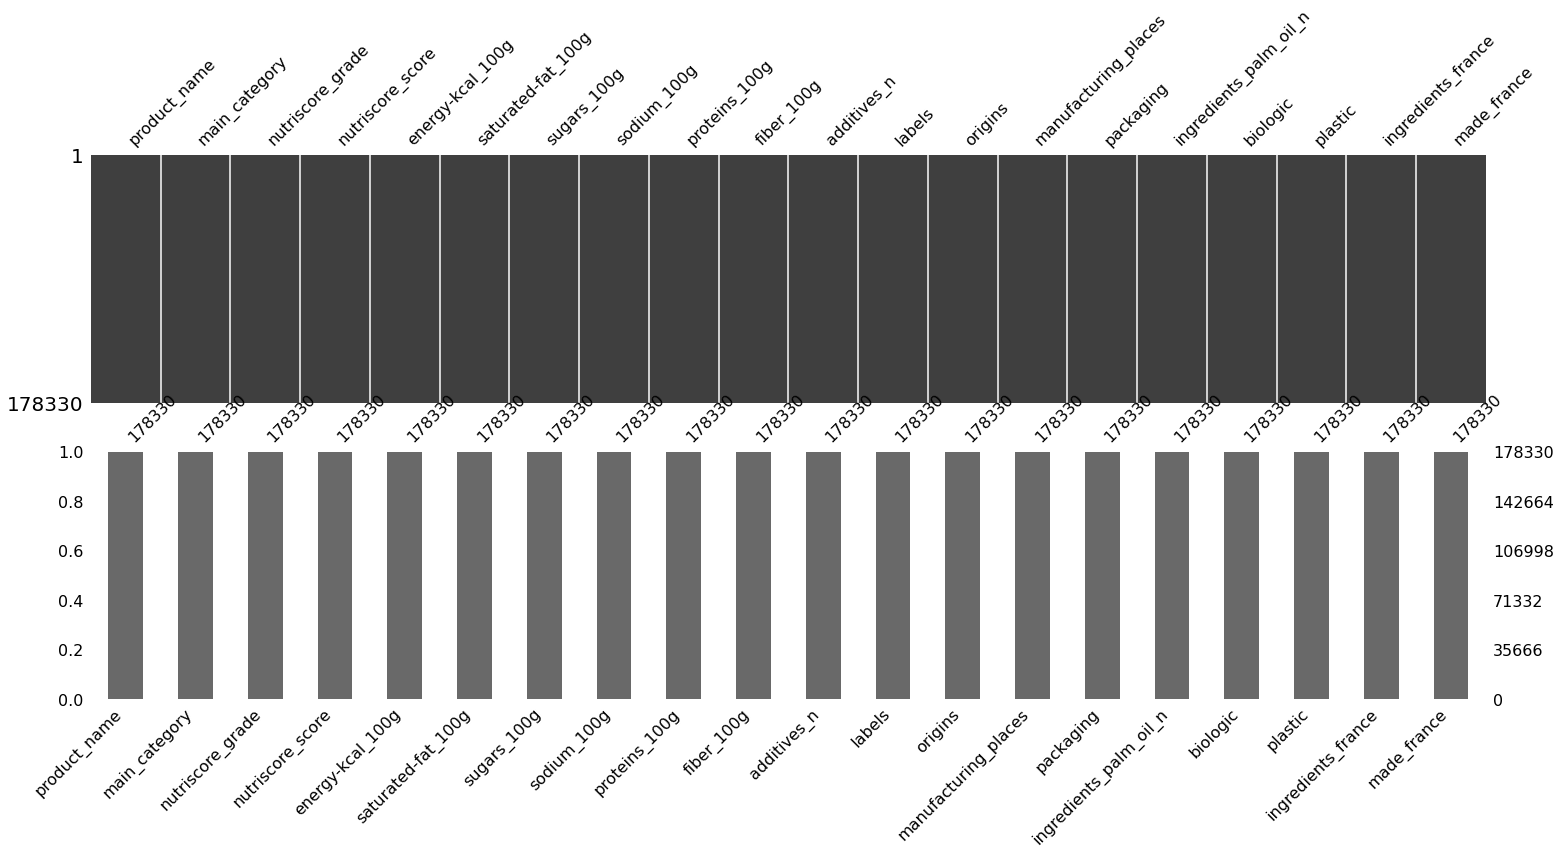

In [37]:
nan_explore(df)

<hr/>

## IV. Exportation des données cleanées

In [40]:
df.to_csv('../Dataset/cleaned_data.csv',sep="\t", index=False)